# Mask to BEV

## Libraries

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from datasets import load_dataset
from PIL import Image

## Load saved masks

In [2]:
def load_predicted_masks(mask_dir):
    mask_files = sorted(f for f in os.listdir(mask_dir) if f.endswith(".npy"))
    masks = [np.load(os.path.join(mask_dir, f)) for f in mask_files]
    return masks

pred_masks = load_predicted_masks("predicted_masks/val")

In [82]:
def get_ipm_homography(
    src_size=(512, 512),
    dst_size=(512, 512),
    fov_deg=100,
    cam_height=2.0,
    tilt_deg=60
):
    """
    Compute homography for IPM projection to ground plane (y=0).
    """
    H, W = src_size
    dst_H, dst_W = dst_size

    # Intrinsics
    f = (W/2) / np.tan(np.radians(fov_deg/2))
    cx, cy = W / 2, H / 2
    K = np.array([[f, 0, cx],
                  [0, f, cy],
                  [0, 0, 1]])

    K_inv = np.linalg.inv(K)

    # Rotation matrix (camera tilted down by tilt_deg degrees)
    tilt_rad = np.radians(tilt_deg)
    R = np.array([
        [1, 0,            0],
        [0, np.cos(tilt_rad), -np.sin(tilt_rad)],
        [0, np.sin(tilt_rad),  np.cos(tilt_rad)],
    ])

    # Ground plane normal (Z=0 world)
    n = np.array([[0], [1], [0]])  # up direction in world frame
    d = cam_height

    # Compute homography H = K * (R - (T n^T) / d) * K^-1
    T = np.array([[0], [-d], [0]])  # camera height in world coords
    H_ipm = K @ (R - (T @ n.T) / d) @ K_inv

    return H_ipm

def draw_grid(img, spacing=50, color=(255, 0, 0)):
    if not isinstance(img, np.ndarray):
        img = np.array(img.convert("RGB"))  # Convert to NumPy RGB array

    grid_img = img.copy()
    for x in range(0, grid_img.shape[1], spacing):
        cv2.line(grid_img, (x, 0), (x, grid_img.shape[0]), color, 1)
    for y in range(0, grid_img.shape[0], spacing):
        cv2.line(grid_img, (0, y), (grid_img.shape[1], y), color, 1)

    return grid_img

def warp_ipm(image, homography, dst_size=(512, 512)):
    return cv2.warpPerspective(image, homography, (dst_size[1], dst_size[0]), flags=cv2.INTER_NEAREST)

def visualize_ipm(raw_image, pred_mask, color_map=None):
    # Convert raw image if it's PIL or Tensor
    if not isinstance(raw_image, np.ndarray):
        raw_image = np.array(raw_image.convert("RGB"))

    if color_map is not None:
        color_mask = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
        for idx, color in enumerate(color_map):
            color_mask[pred_mask == idx] = color
    else:
        color_mask = pred_mask.astype(np.uint8) * 80  # grayscale fallback

    # Homography
    H_ipm = get_ipm_homography(
        src_size=raw_image.shape[:2],
        dst_size=(512, 512),
        fov_deg=150,
        cam_height=1.0,
        tilt_deg=40
    )

    ipm_image = warp_ipm(raw_image, H_ipm)
    ipm_mask = warp_ipm(color_mask, H_ipm)

    # Plot: 2×2 layout
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(raw_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(color_mask)
    plt.title("Original Predicted Mask")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(ipm_image)
    plt.title("IPM Applied to Image")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(ipm_mask)
    plt.title("IPM Applied to Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [58]:
ds = load_dataset("Wilbur1240/MaSTr1325_512x384", split="train")
raw_splits = ds.train_test_split(test_size=0.1, seed=42)
raw_train_dataset = raw_splits["train"]
raw_valid_dataset = raw_splits["test"]
ds = {
    "train": raw_train_dataset,
    "validation": raw_valid_dataset,
}
color_map = [
    (0, 255, 0),      # sea
    (0, 0, 255),      # obstacle
    (255, 0, 0),      # sky
    (0, 0, 0)         # background / ignored
]

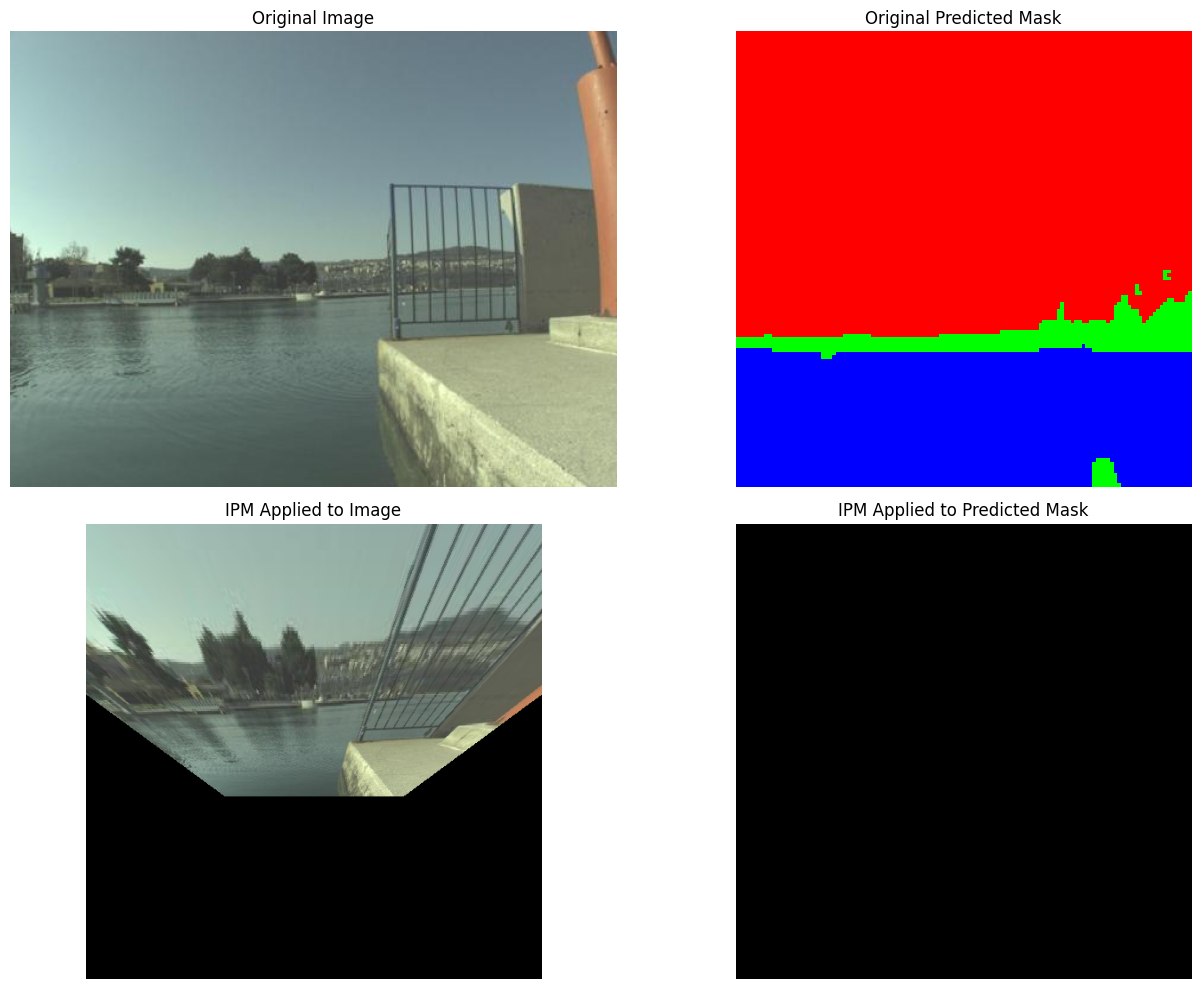

In [83]:
idx = 10
# raw_sample = ds["train"][390]
raw_image = cv2.imread("/workspace/data/MaSTr1325_renamed/images_512x384/0399.jpg")
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
pred_mask = pred_masks[idx]
visualize_ipm(raw_image, pred_mask, color_map=color_map)

Shape: (384, 512)
Dtype: uint8


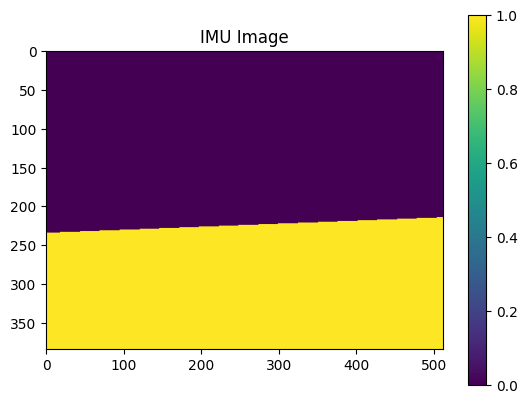

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imu_img = cv2.imread('../data/MaSTr1325_renamed/imus_512x384/0200.png', cv2.IMREAD_UNCHANGED)
print("Shape:", imu_img.shape)
print("Dtype:", imu_img.dtype)
plt.imshow(imu_img)
plt.colorbar()
plt.title("IMU Image")
plt.show()